In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import joblib
from utils.data_loader import load_as_maps
from models.swin_transformer import PatchEmbedding, SwinTransformer, patch_extract, masked_mse_loss
import keras

In [ ]:
# load data
features, targets = load_as_maps(start_year=1958, end_year=2018, datasets=["exp1", "exp5", "exp6", "exp7"])

# split data
X_train = features[:int(0.8 * len(features))]
Y_train = targets[:int(0.8 * len(targets))]
X_val = features[int(0.8 * len(features)):int(0.9 * len(features))]
Y_val = targets[int(0.8 * len(targets)):int(0.9 * len(targets))]
X_test = features[int(0.9 * len(features)):]
Y_test = targets[int(0.9 * len(targets)):]

# scale data
scaler = MinMaxScaler()
n_samples, h, w, n_features = X_train.shape
X_train_flat = X_train.reshape(-1,n_features)
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train = X_train_scaled_flat.reshape(n_samples, h, w, n_features)


n_samples, h, w, n_features = X_val.shape
X_val_flat = X_val.reshape(-1,n_features)
X_val_scaled_flat = scaler.transform(X_val_flat)
X_val = X_val_scaled_flat.reshape(n_samples, h, w, n_features)

n_samples, h, w, n_features = X_test.shape
X_test_flat = X_test.reshape(-1,n_features)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_test = X_test_scaled_flat.reshape(n_samples, h, w, n_features)

# save scaler
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
folder_path = "../../outputs/swin/" + timestamp
os.makedirs(folder_path, exist_ok=True)

joblib.dump(scaler, folder_path + '/scaler.pkl')

In [ ]:
input_shape = (168, 360, 13)

patch_size = (4, 4)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 512  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
# image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]
print(f"Number of patches: {num_patch_x} x {num_patch_y}")

learning_rate = 0.0005
batch_size = 128
num_epochs = 20
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

Number of patches: 42 x 90


In [4]:
mask = features[0,:,:,10]
print(tf.reduce_sum(mask))

tf.Tensor(42539.0, shape=(), dtype=float64)


In [ ]:
input = tf.keras.layers.Input(shape=(3780, 208))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = tf.keras.layers.Reshape((num_patch_x, num_patch_y, embed_dim))(x)
x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
output = tf.keras.layers.Conv2D(1, 1, activation='linear')(x)
output = tf.keras.layers.Cropping2D(((0, 1), (0, 0)))(output)
mask_batched = tf.expand_dims(mask, axis=0)  
mask_expanded = tf.expand_dims(mask_batched, -1)
output = output * mask_expanded



/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'window_attention_1' (of type WindowAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    .batch(batch_size)
    .map(lambda x, y: (patch_extract(x,patch_size), y))
    .prefetch(tf.data.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((X_val, Y_val))
    .batch(batch_size)
    .map(lambda x, y: (patch_extract(x,patch_size), y))
    .prefetch(tf.data.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    .batch(batch_size)
    .map(lambda x, y: (patch_extract(x,patch_size), y))
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
model = keras.Model(input, output)
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss="mse",#masked_mse_loss(mask),
    metrics=["mae"],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 490.7949 - mae: 2.3037 - val_loss: 44.0976 - val_mae: 1.8395


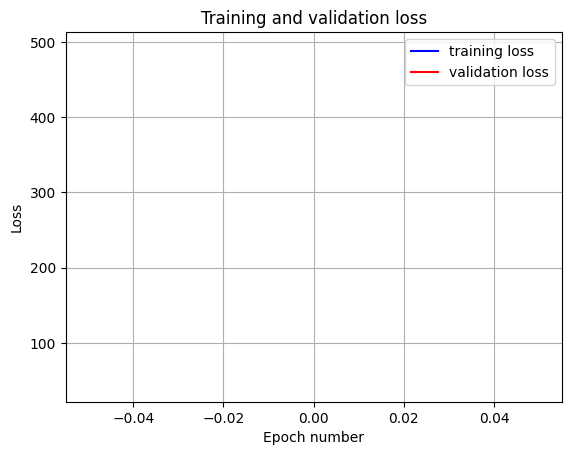

In [8]:
model.save(folder_path + "/model.keras")

plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = folder_path + '/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'window_attention_3' (of type WindowAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layer

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step


/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'window_attention_5' (of type WindowAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layer

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x380fb2340> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step


/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/src/utils/model_analysis.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step


/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'window_attention_9' (of type WindowAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/keras/src/layer

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step


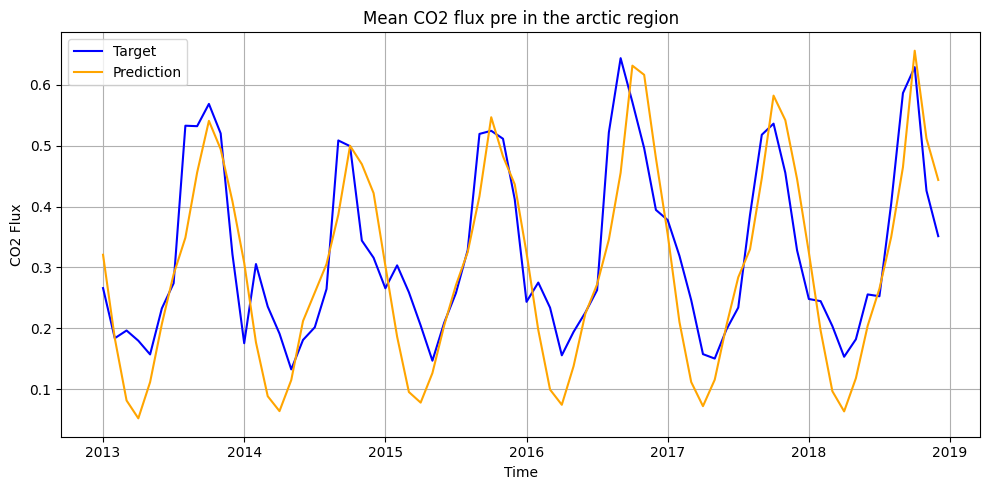

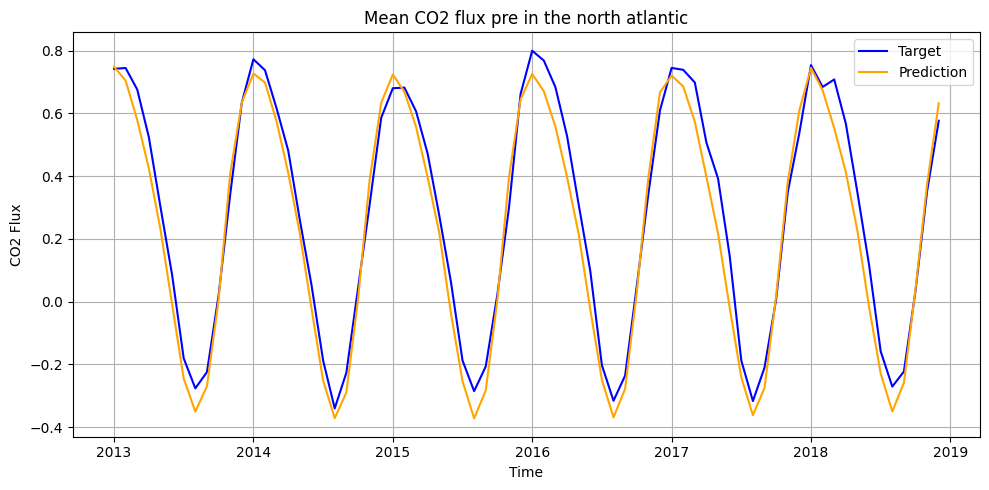

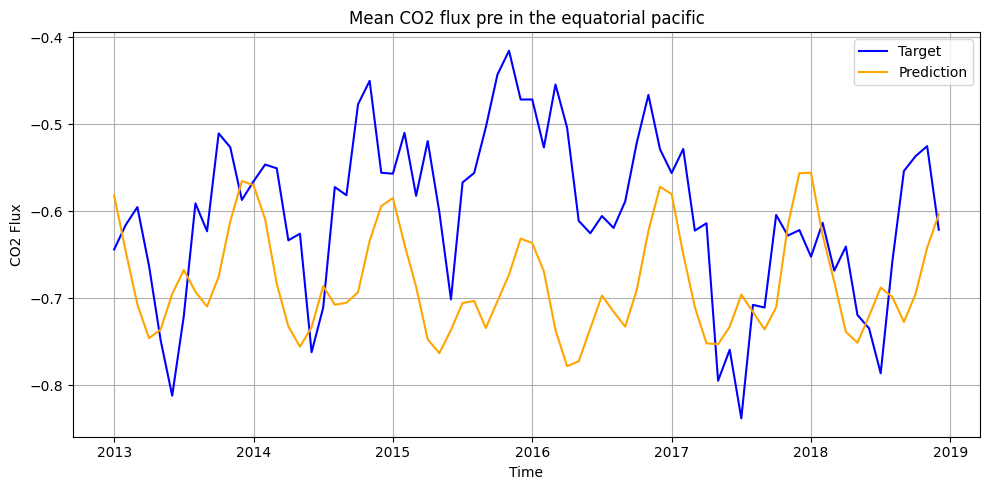

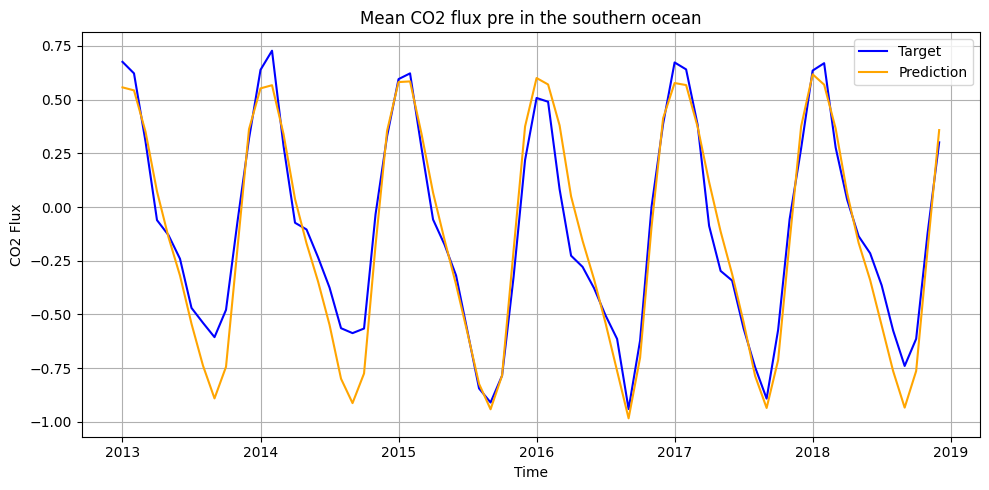

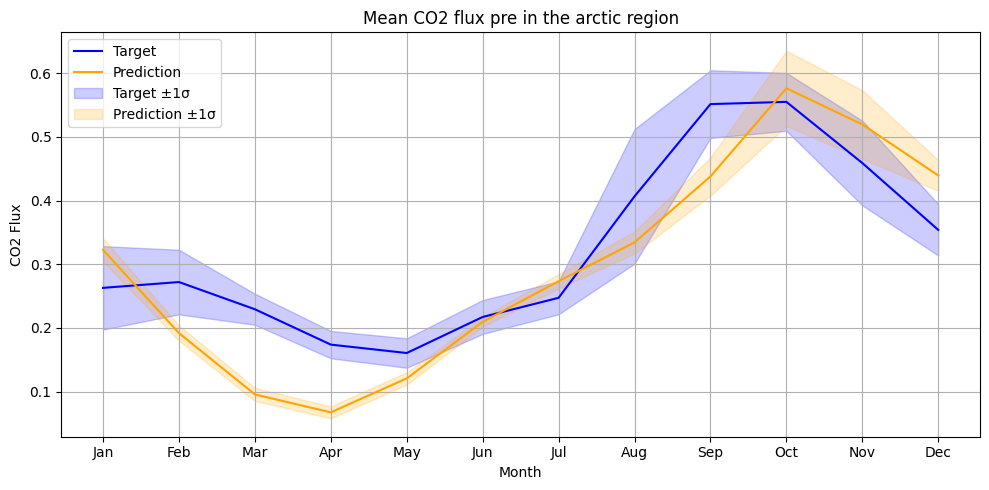

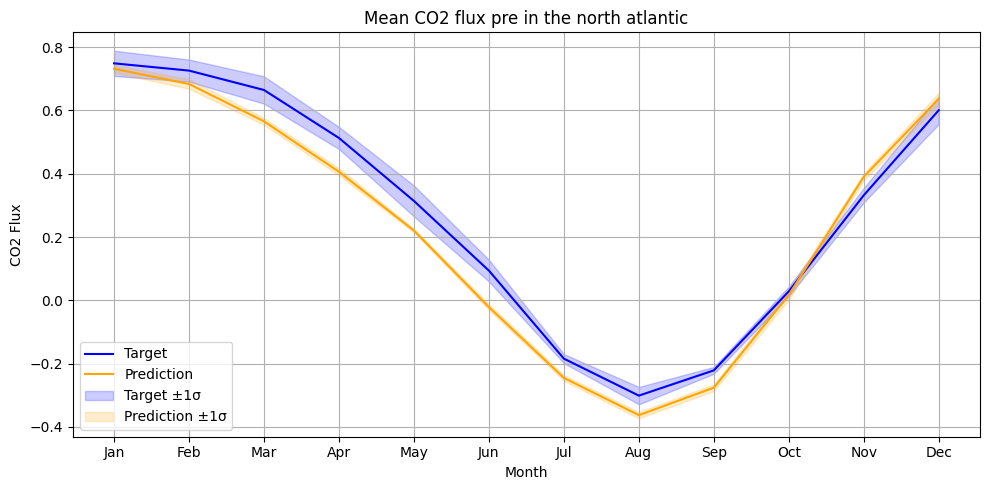

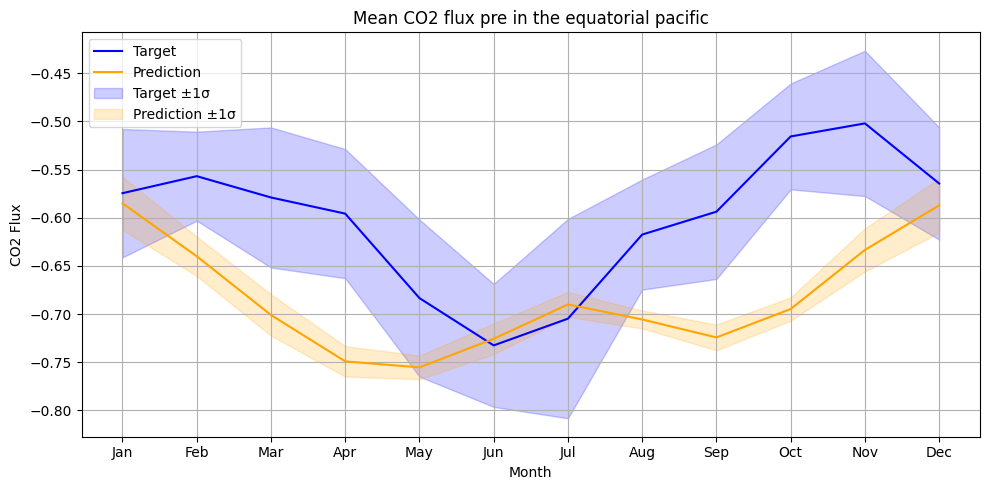

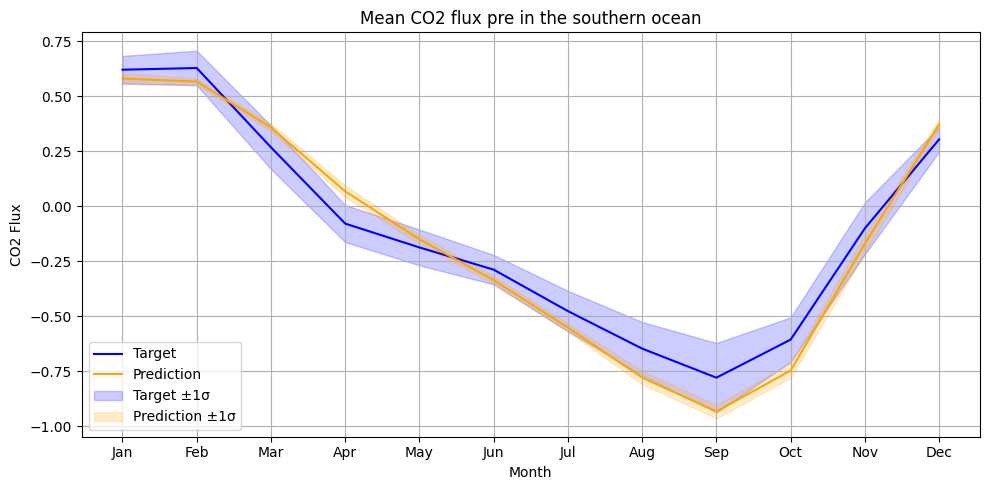

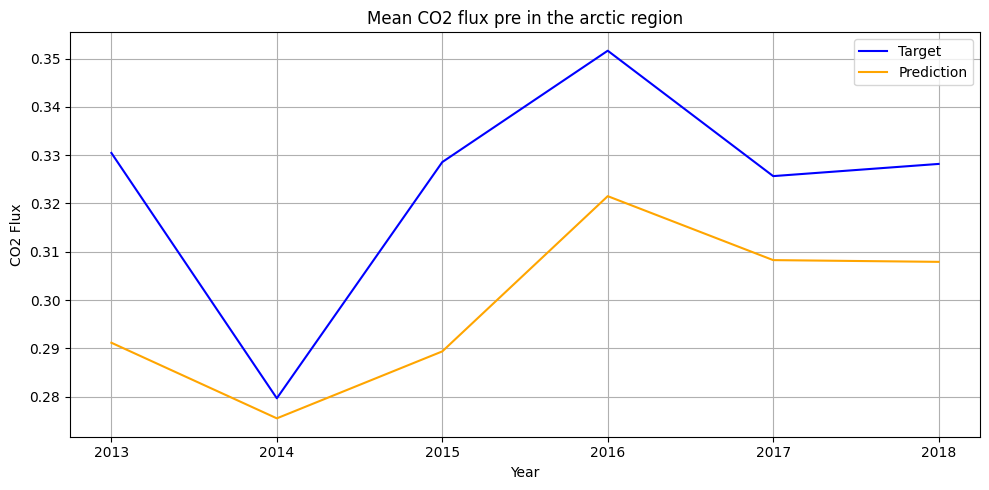

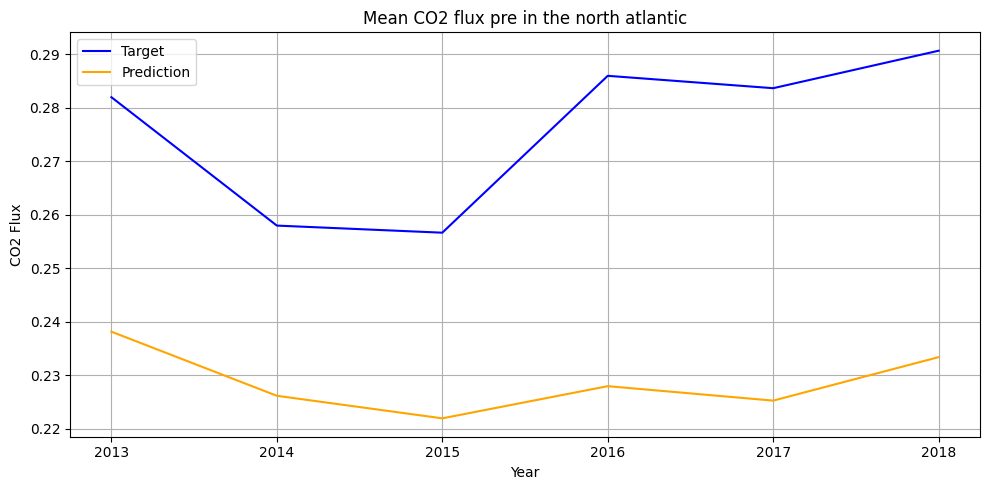

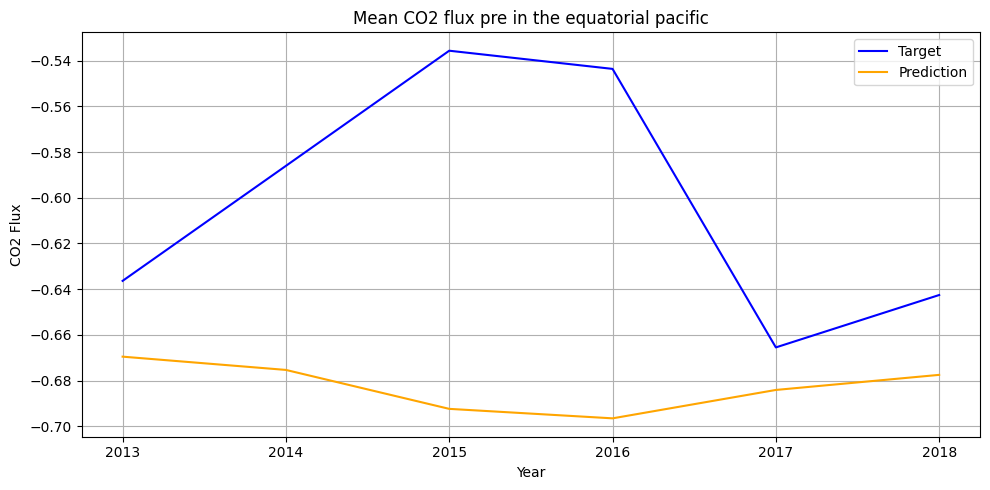

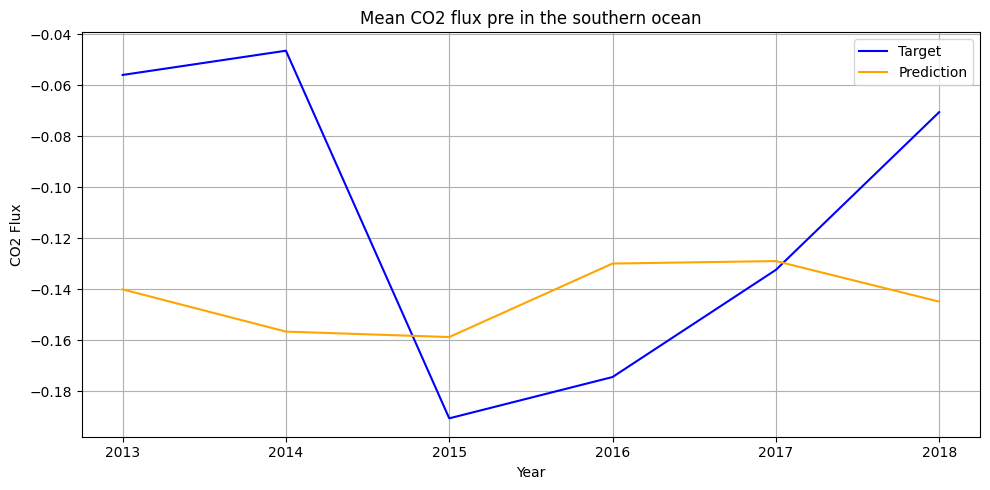

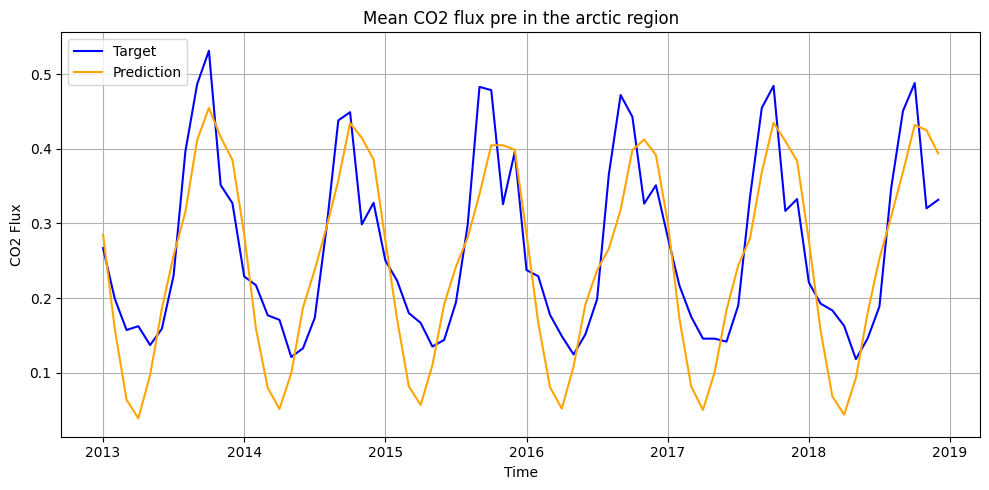

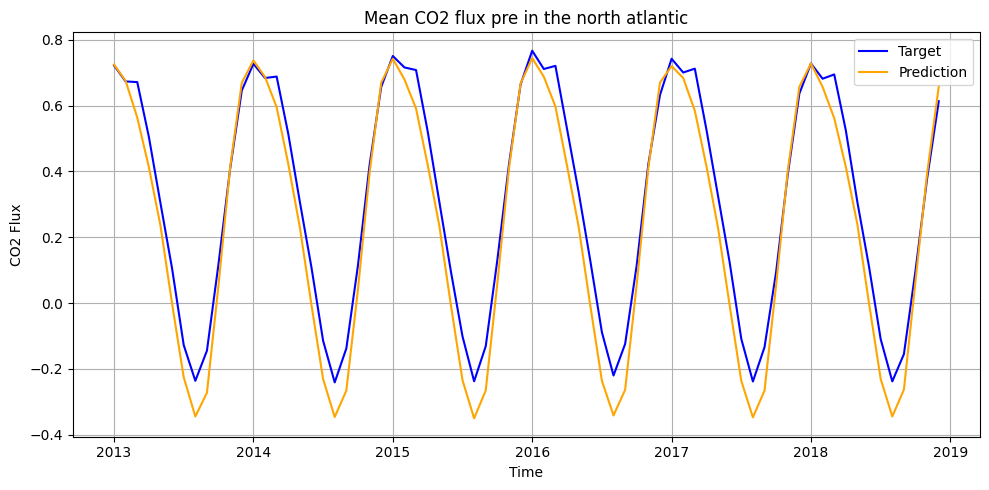

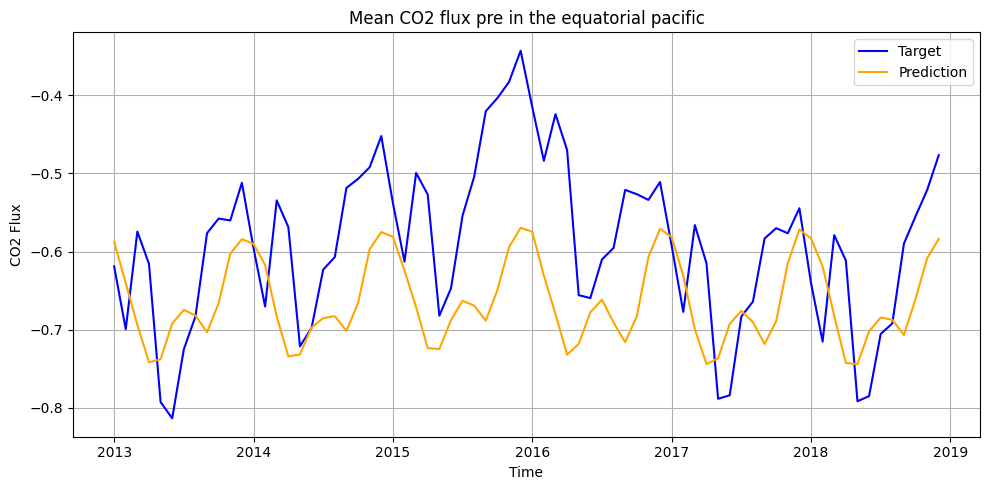

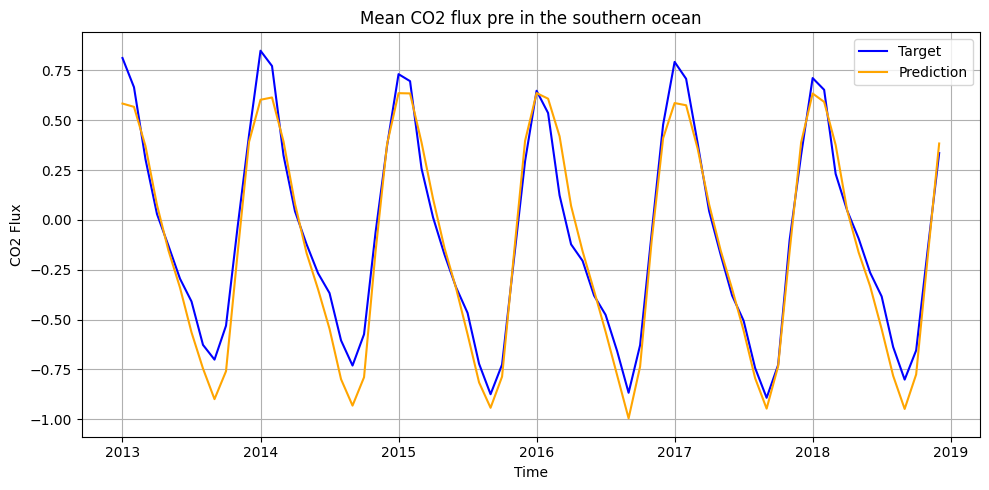

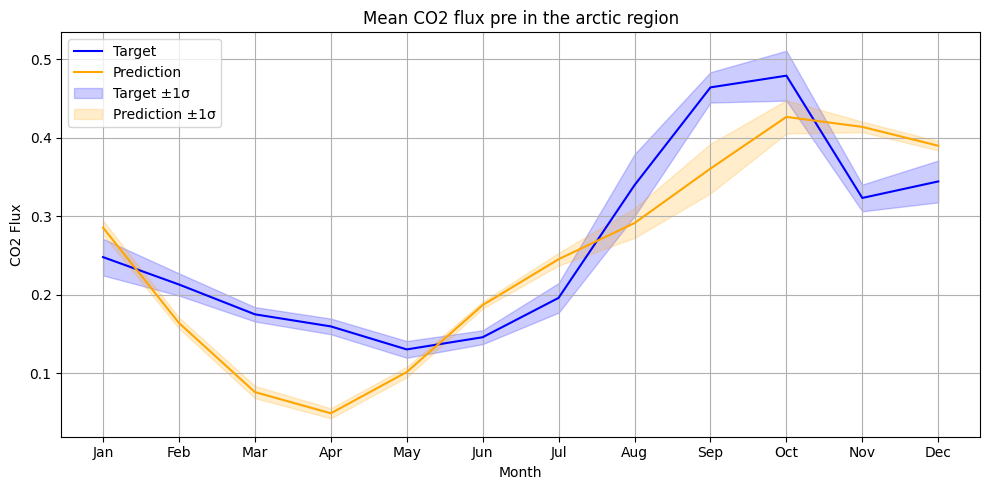

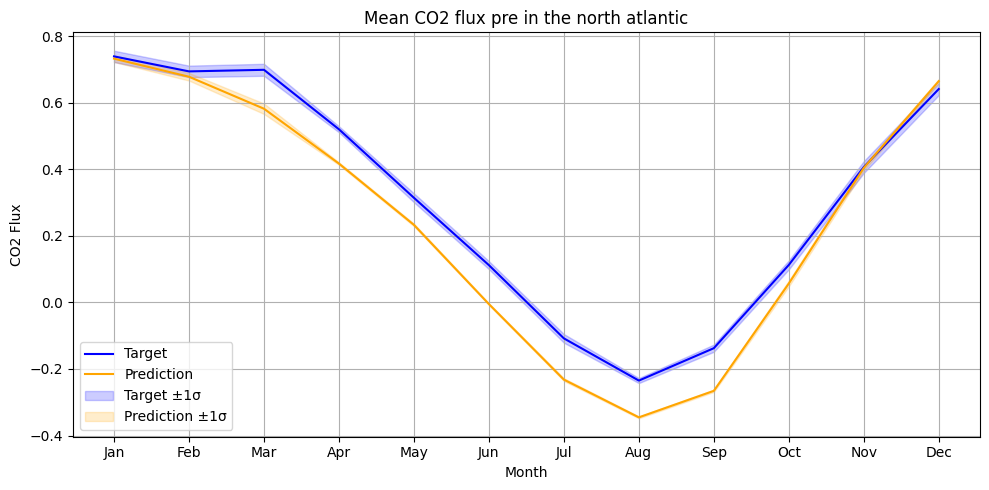

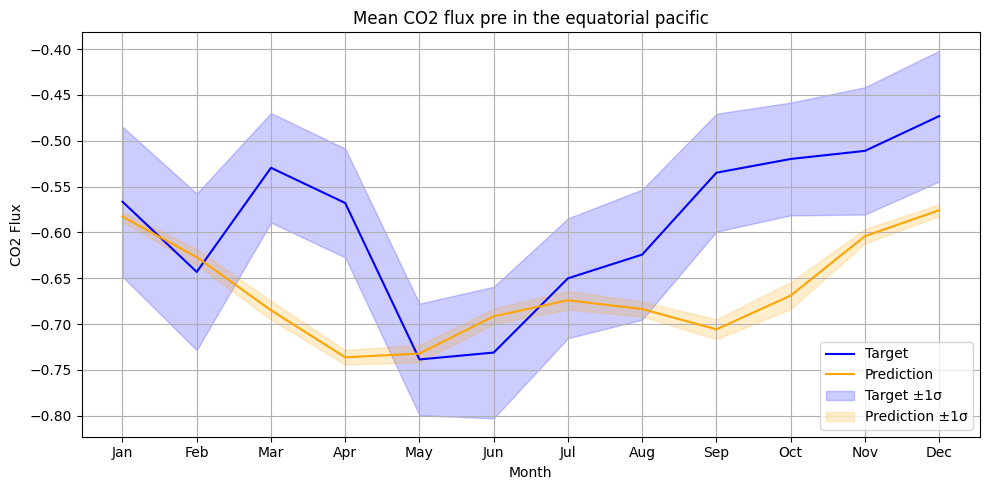

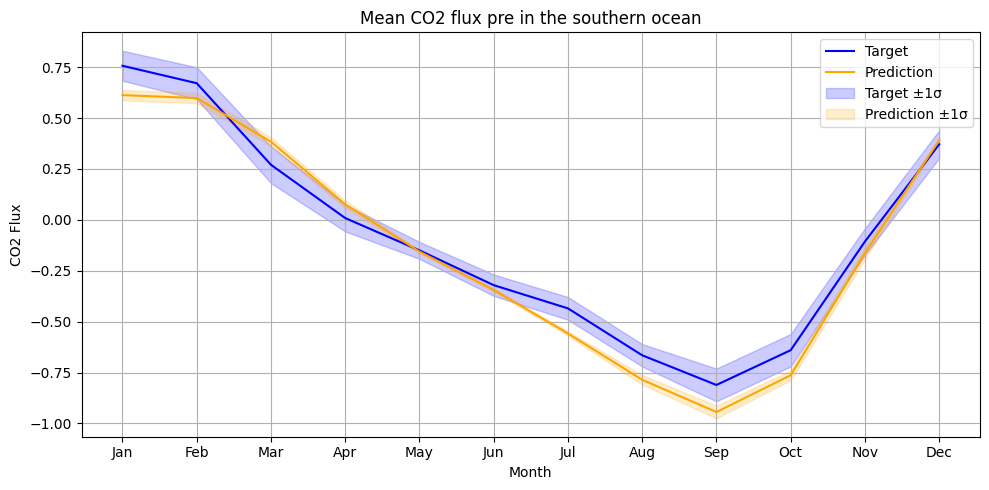

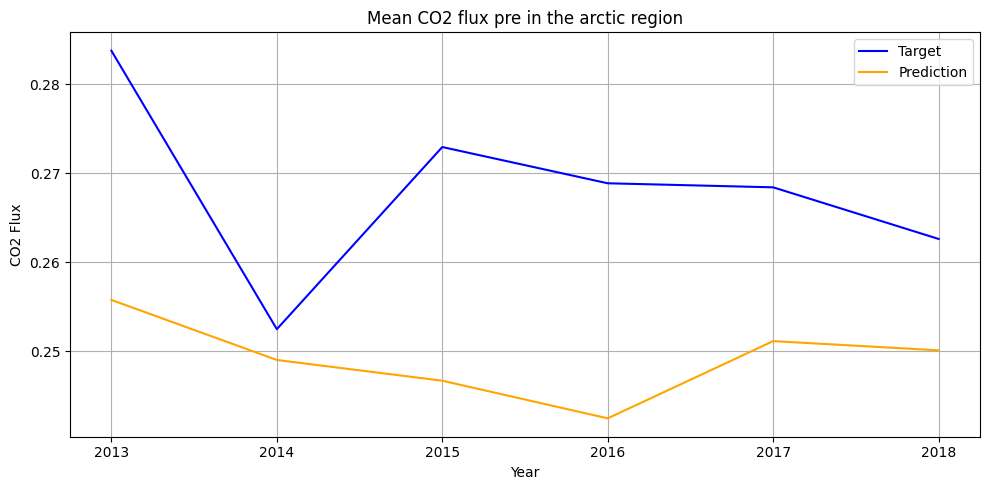

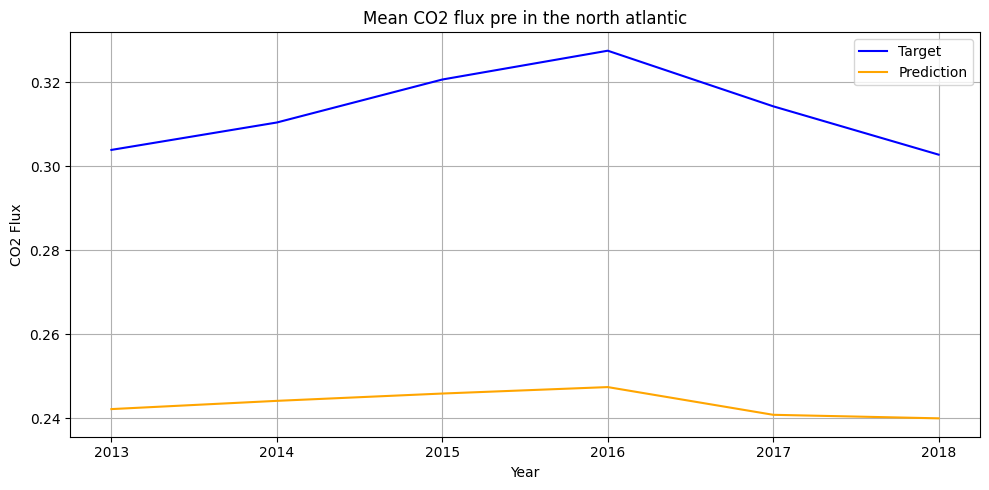

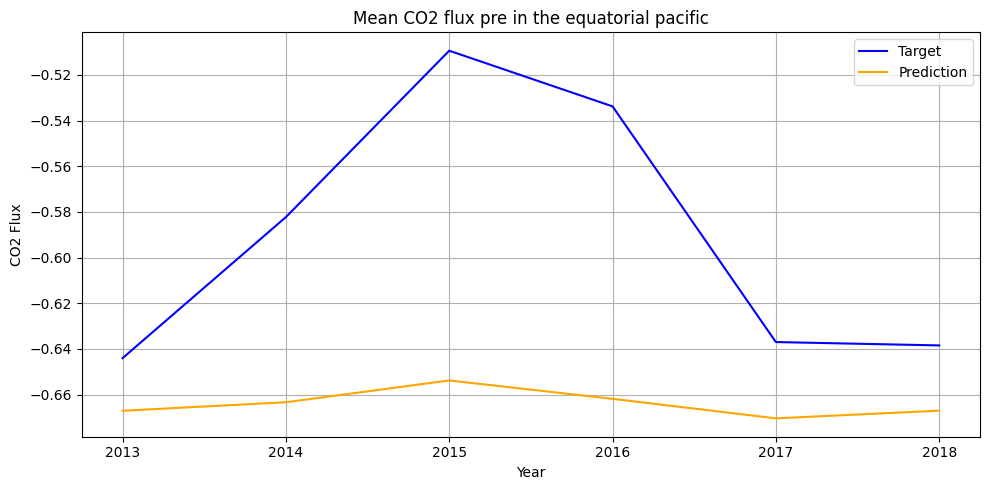

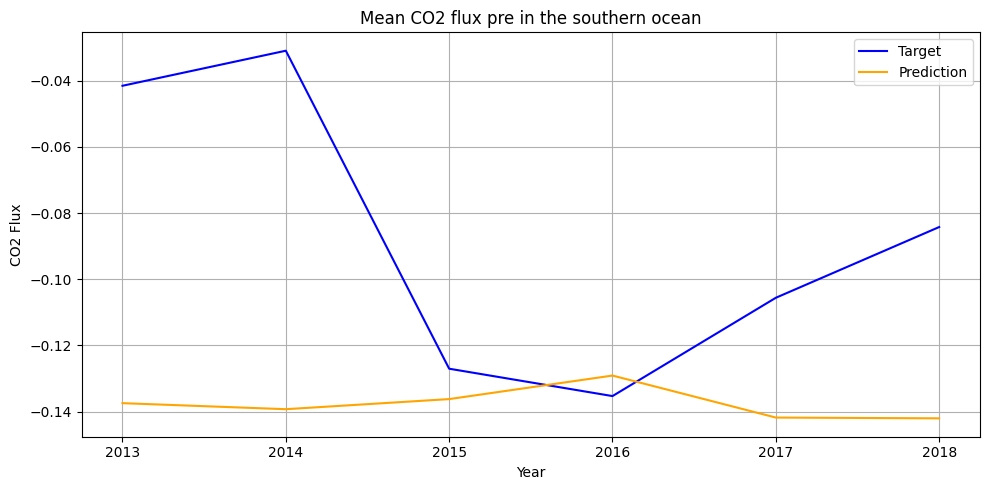

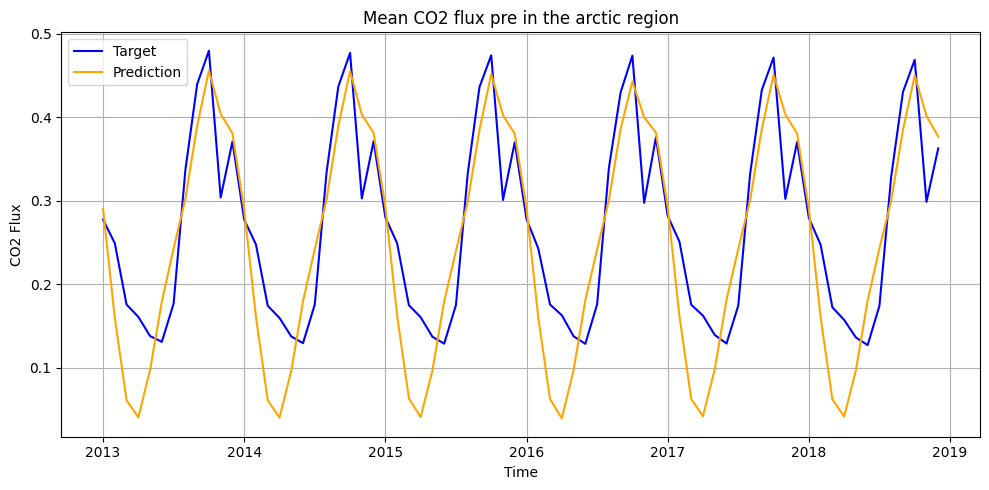

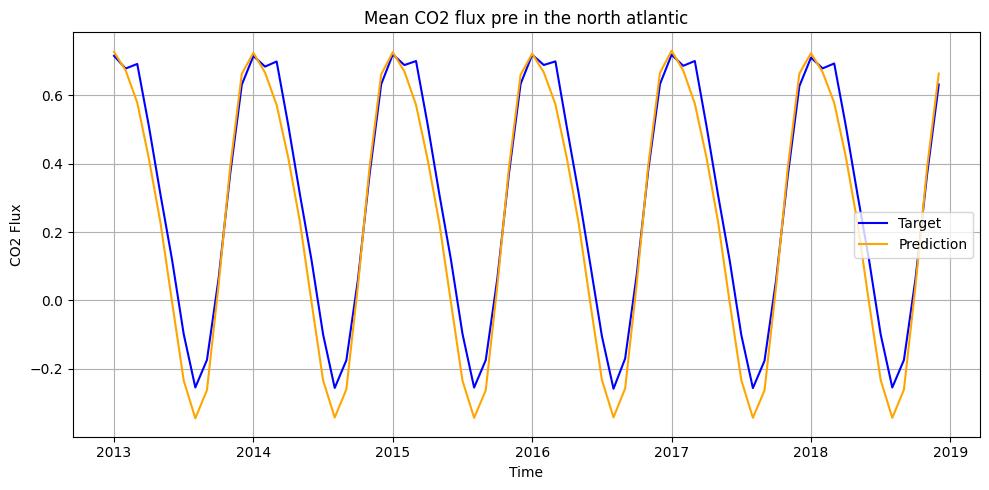

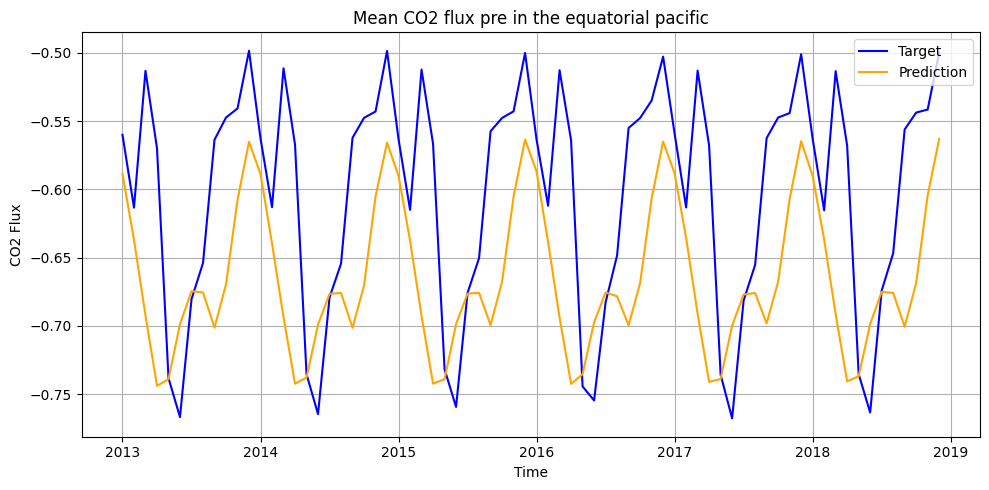

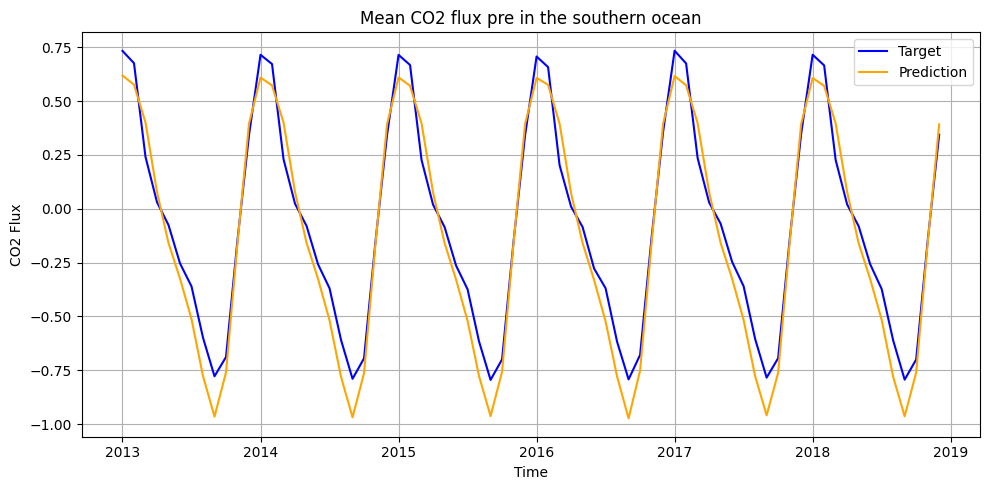

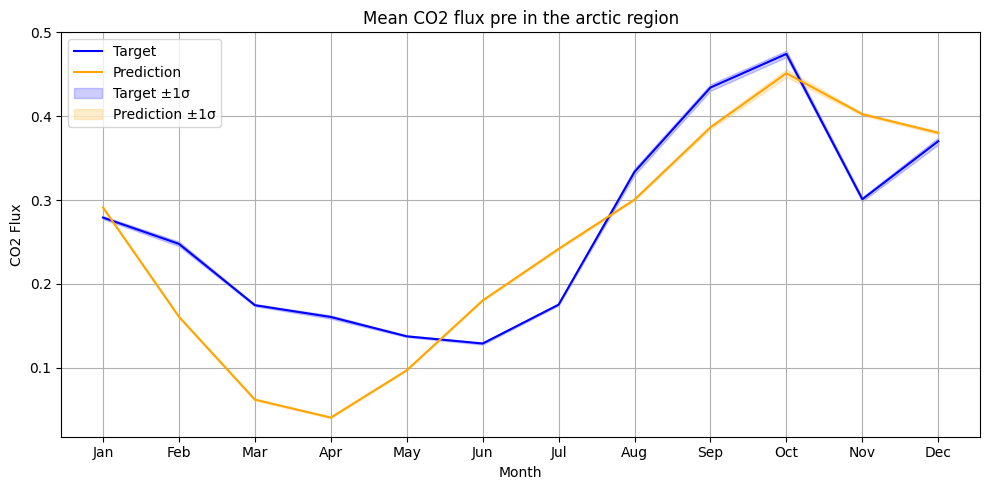

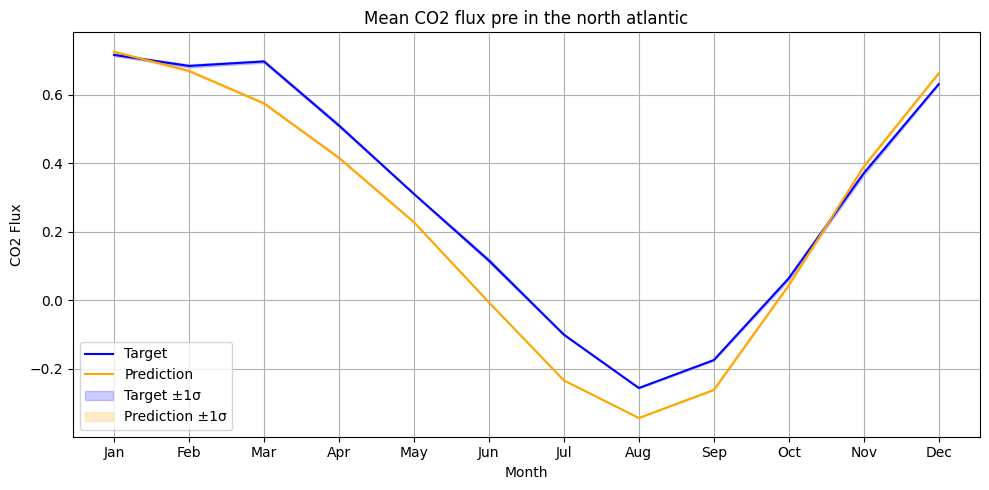

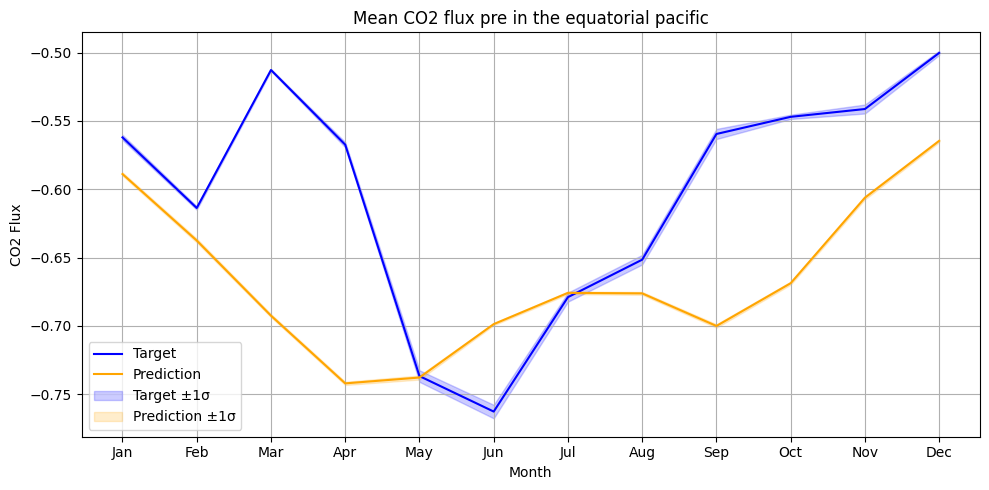

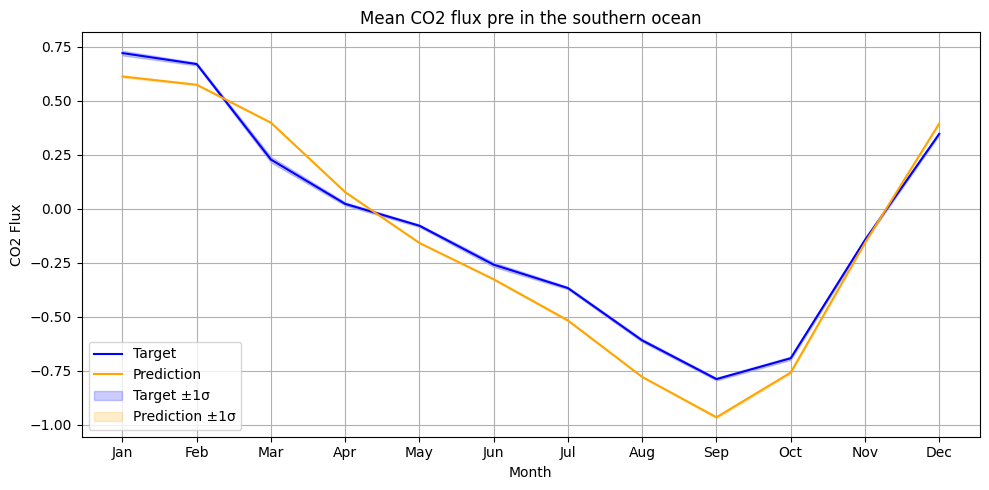

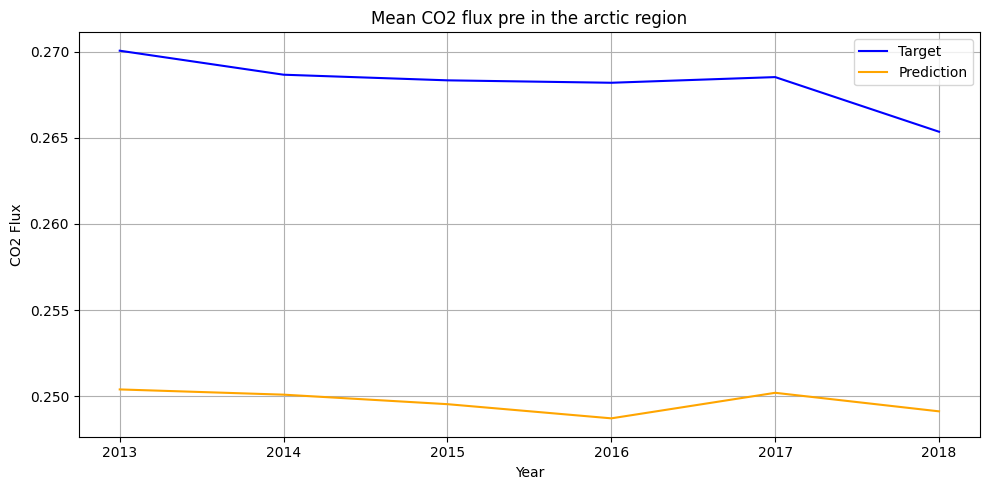

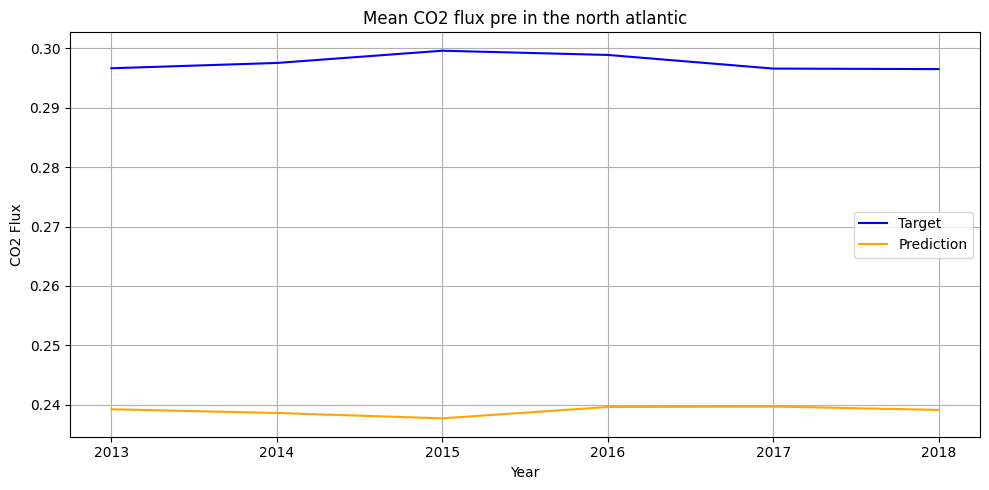

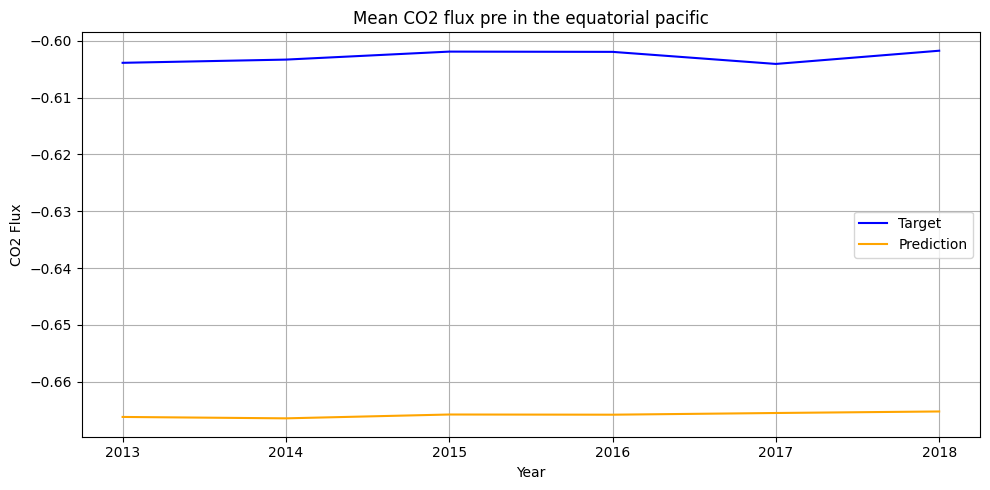

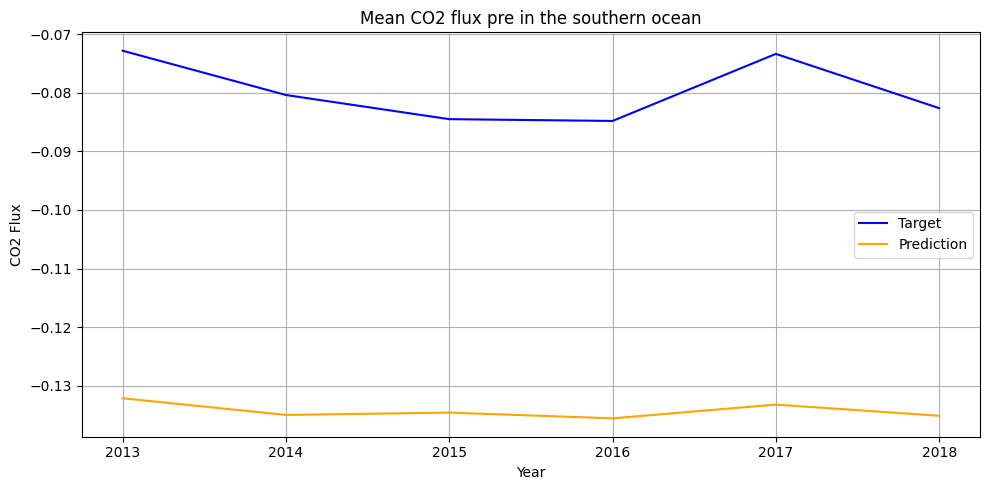

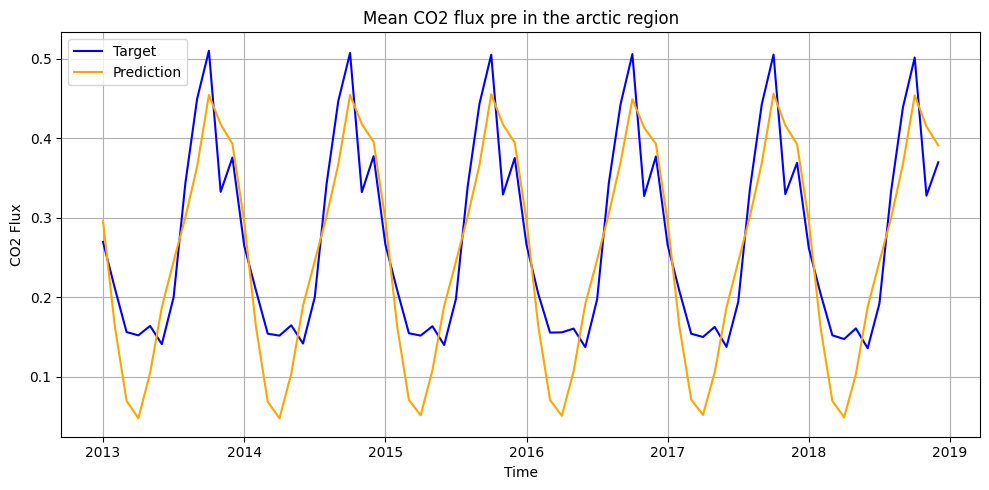

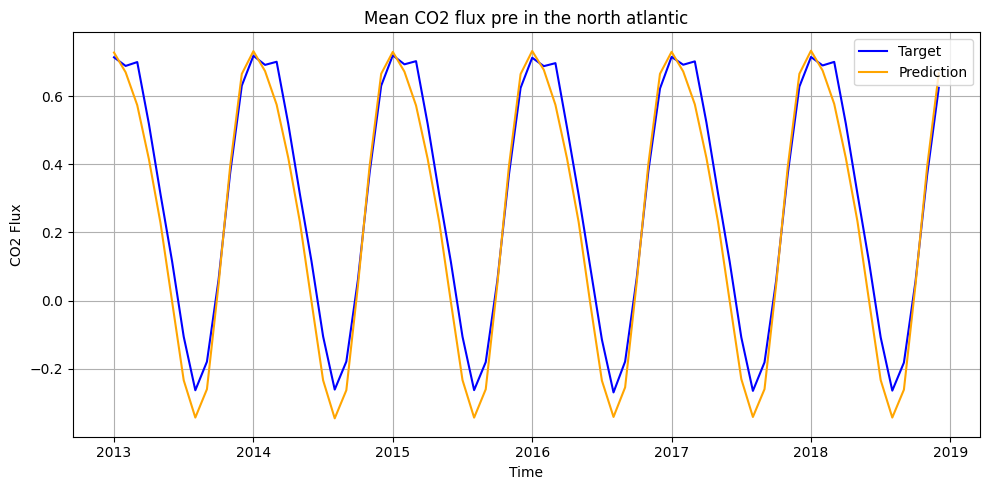

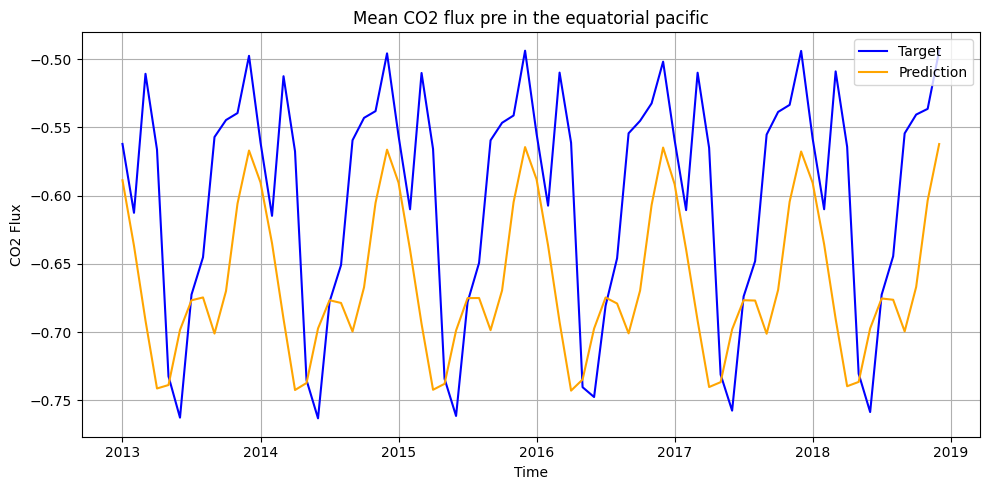

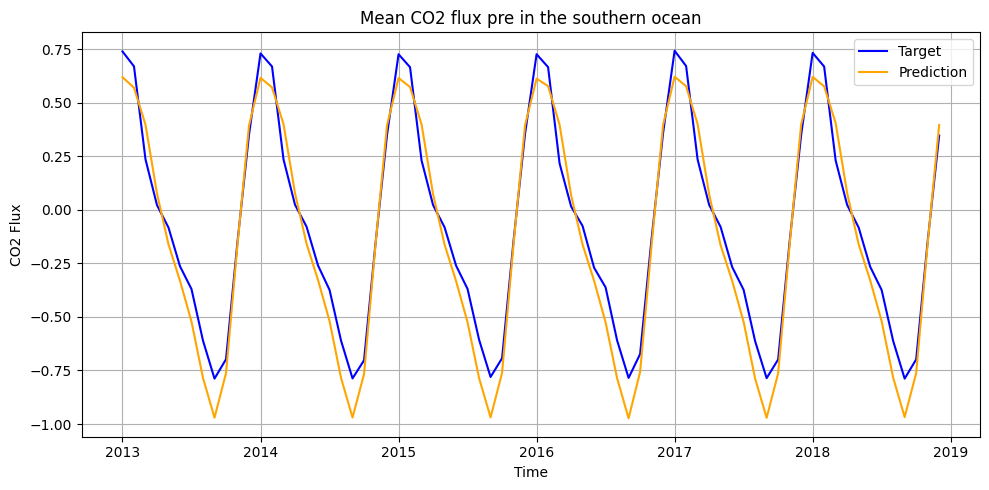

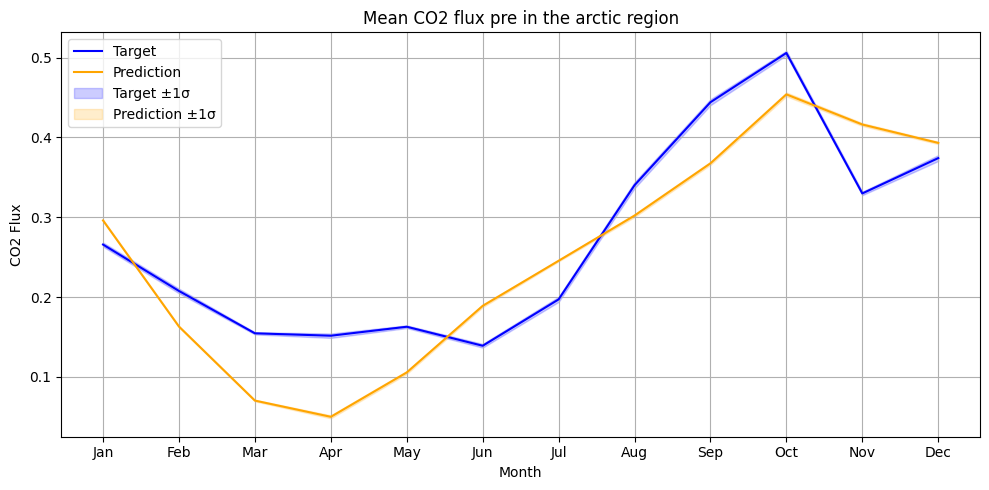

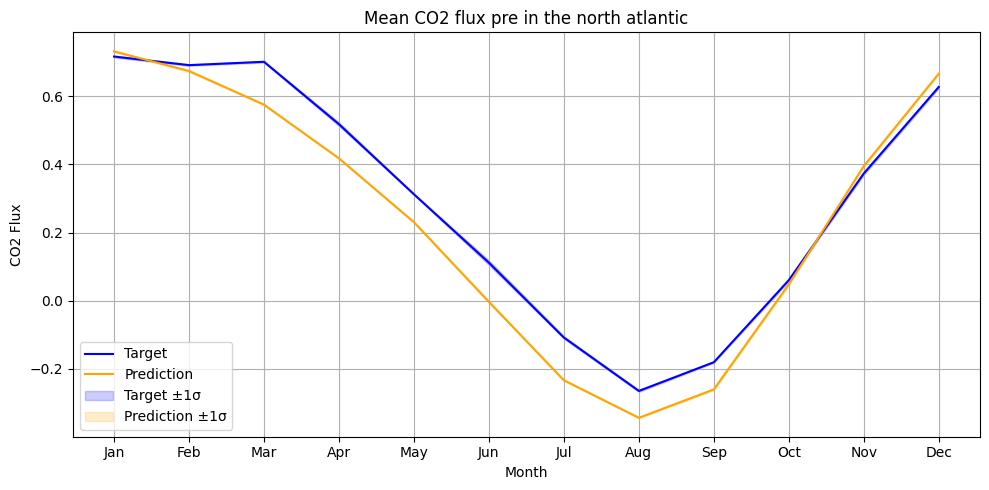

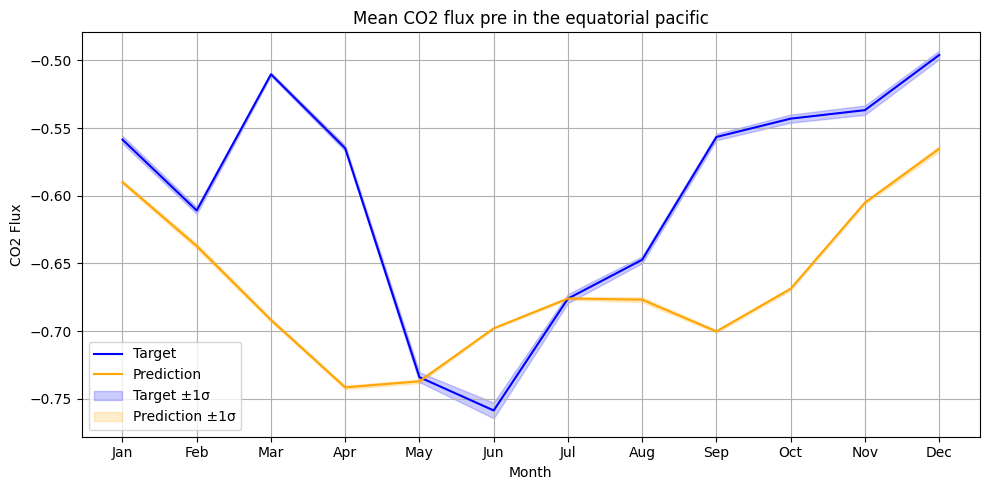

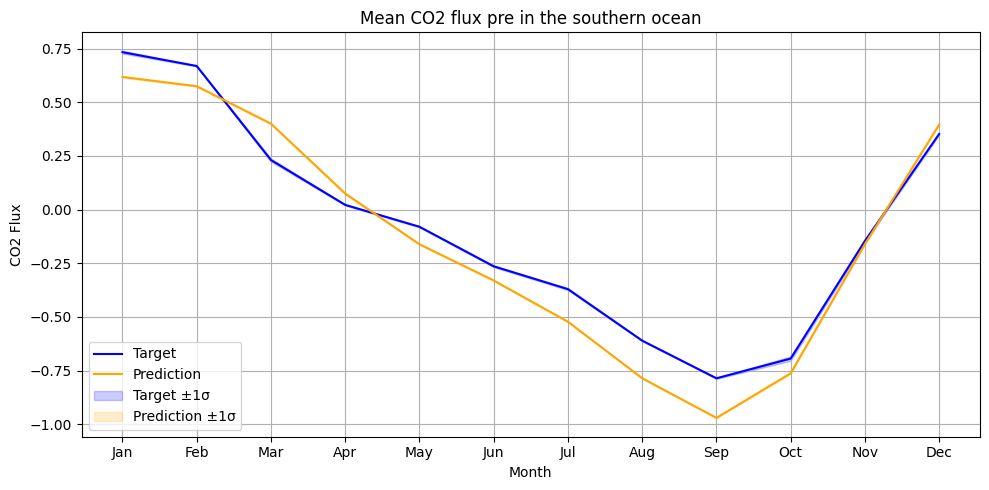

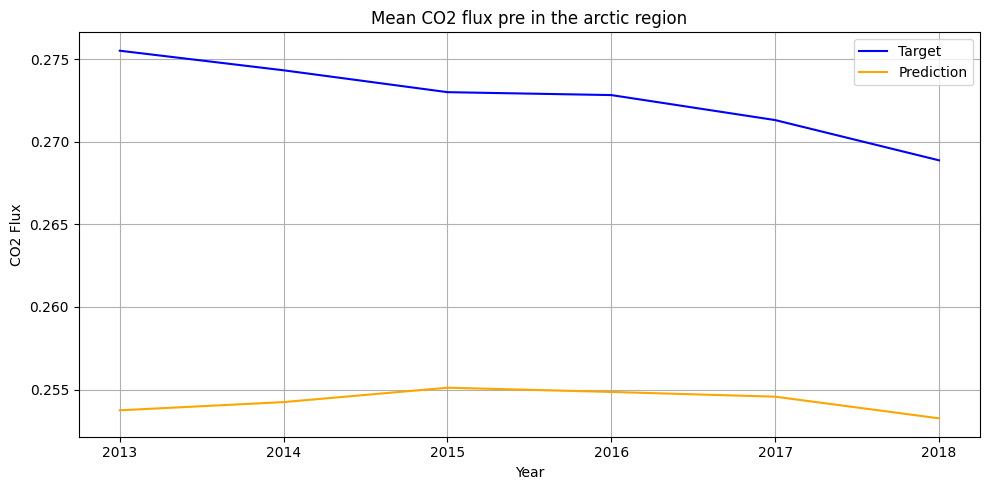

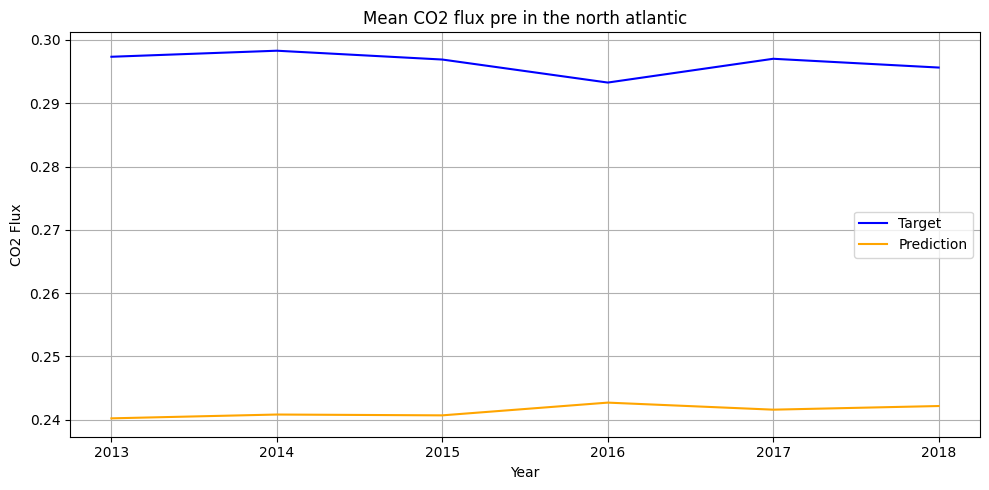

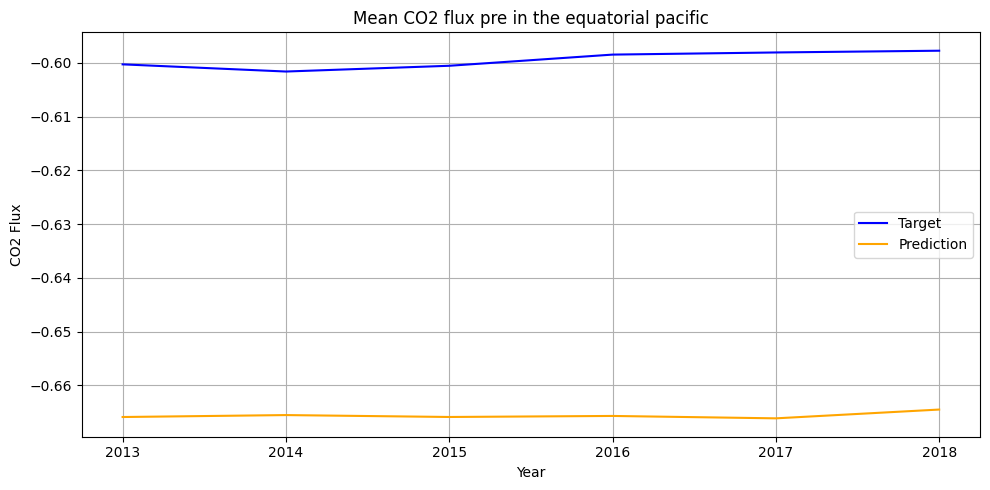

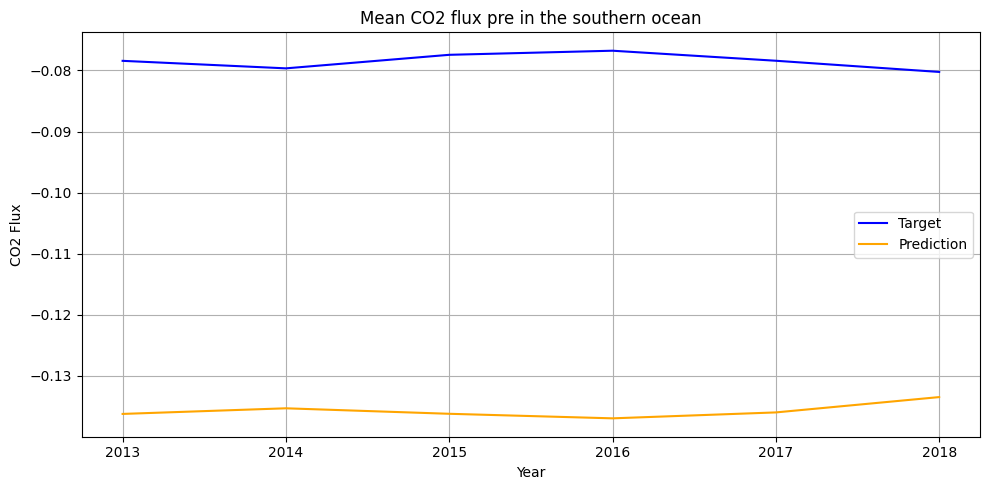

In [ ]:
from utils.model_analysis import complete_model_analysis_map

complete_model_analysis_map(folder_path,"exp1")
complete_model_analysis_map(folder_path,"exp5")
complete_model_analysis_map(folder_path,"exp6")
complete_model_analysis_map(folder_path,"exp7")
# complete_model_analysis_map("../../outputs/swin/2025-10-01_10-00","exp1")
# complete_model_analysis_map("../../outputs/swin/2025-10-01_10-00","exp5")
# complete_model_analysis_map("../../outputs/swin/2025-10-01_10-00","exp6")
# complete_model_analysis_map("../../outputs/swin/2025-10-01_10-00","exp7")